# Building Models for eCommerce Fraud Detection

## Table of Contents
*  
    * [Part 1 : Data Loading, Transformation and Exploration](#part-1)
    * [Part 2 : Feature extraction and ML training](#part-2)
    * [Part 3 : Customer Segmentation and Knowledge sharing with K-Mean](#part-3)
    * [Part 4 : Data Ethics, Privacy, and Security](#part-4)
 
Please add code/markdown cells if needed.

# Part 1: Data Loading, Transformation and Exploration <a class="anchor" name="part-1"></a>
## 1.1 Data Loading
In this section, we must load the given datasets into PySpark DataFrames and use DataFrame functions to process the data. Spark SQL usage is discouraged, and you can only use pandas to format results. For plotting, various visualisation packages can be used, but please ensure that you have included instructions to install the additional packages and that the installation will be successful in the provided docker container (in case your marker needs to clear the notebook and rerun it).

### 1.1.1 Data Loading <a class="anchor" name="1.1"></a>
1.1.1 Write the code to create a SparkSession. For creating the SparkSession, you need to use a SparkConf object to configure the Spark app with a proper application name, to ensure the maximum partition size does not exceed 16MB, and to run locally with all CPU cores on your machine (note: if you have insufficient RAM, reducing the number of cores is acceptable.)  (2%)

In [1]:
from pyspark.sql import SparkSession
from pyspark import SparkConf

spark = SparkSession.builder \
    .appName("eCommerce Fraud Detection") \
    .config("spark.sql.files.maxPartitionBytes", "16MB") \
    .master("local[*]") \
    .getOrCreate()

print(spark.sparkContext.getConf().getAll())

[('spark.app.name', 'eCommerce Fraud Detection'), ('spark.app.startTime', '1727422406124'), ('spark.app.id', 'local-1727422406588'), ('spark.executor.id', 'driver'), ('spark.driver.host', 'c369b47f95d8'), ('spark.driver.extraJavaOptions', '-Djava.net.preferIPv6Addresses=false -XX:+IgnoreUnrecognizedVMOptions --add-opens=java.base/java.lang=ALL-UNNAMED --add-opens=java.base/java.lang.invoke=ALL-UNNAMED --add-opens=java.base/java.lang.reflect=ALL-UNNAMED --add-opens=java.base/java.io=ALL-UNNAMED --add-opens=java.base/java.net=ALL-UNNAMED --add-opens=java.base/java.nio=ALL-UNNAMED --add-opens=java.base/java.util=ALL-UNNAMED --add-opens=java.base/java.util.concurrent=ALL-UNNAMED --add-opens=java.base/java.util.concurrent.atomic=ALL-UNNAMED --add-opens=java.base/sun.nio.ch=ALL-UNNAMED --add-opens=java.base/sun.nio.cs=ALL-UNNAMED --add-opens=java.base/sun.security.action=ALL-UNNAMED --add-opens=java.base/sun.util.calendar=ALL-UNNAMED --add-opens=java.security.jgss/sun.security.krb5=ALL-UNNAM

1.1.2 Write code to define the schemas for the category, customer, product, browsing behaviour and transaction datasets, following the data types suggested in the metadata file. (3%)

In [2]:
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, DoubleType, TimestampType, BooleanType, FloatType

# Category Schema
category_schema = StructType([
    StructField("category_id", IntegerType(), True),
    StructField("cat_level1", StringType(), True),
    StructField("cat_level2", StringType(), True),
    StructField("cat_level3", StringType(), True)
])

# Customer Schema
customer_schema = StructType([
    StructField("customer_id", IntegerType(), True),
    StructField("first_name", StringType(), True),
    StructField("last_name", StringType(), True),
    StructField("username", StringType(), True),
    StructField("email", StringType(), True),
    StructField("gender", StringType(), True),
    StructField("birthdate", StringType(), True),  # This can be converted to date later if needed
    StructField("first_join_date", StringType(), True)  # Convert to date if needed
])

# Product Schema
product_schema = StructType([
    StructField("id", IntegerType(), True),
    StructField("gender", StringType(), True),
    StructField("baseColour", StringType(), True),
    StructField("season", StringType(), True),
    StructField("year", IntegerType(), True),
    StructField("usage", StringType(), True),
    StructField("productDisplayName", StringType(), True),
    StructField("category_id", IntegerType(), True)
])

# Customer Session Schema
customer_session_schema = StructType([
    StructField("session_id", StringType(), True),
    StructField("customer_id", IntegerType(), True)
])

# Fraud Transaction Schema
fraud_transaction_schema = StructType([
    StructField("transaction_id", StringType(), True),
    StructField("is_fraud", BooleanType(), True)
])

# Transaction Schema
transaction_schema = StructType([
    StructField("created_at", StringType(), True),  # Convert to timestamp if needed
    StructField("customer_id", IntegerType(), True),
    StructField("transaction_id", StringType(), True),
    StructField("session_id", StringType(), True),
    StructField("product_metadata", StringType(), True),  # Consider parsing JSON data if needed
    StructField("payment_method", StringType(), True),
    StructField("payment_status", StringType(), True),
    StructField("promo_amount", IntegerType(), True),
    StructField("promo_code", StringType(), True),
    StructField("shipment_fee", IntegerType(), True),
    StructField("shipment_location_lat", FloatType(), True),
    StructField("shipment_location_long", FloatType(), True),
    StructField("total_amount", IntegerType(), True),
    StructField("clear_payment", IntegerType(), True)
])

# Browsing Behavior Schema
browsing_behaviour_schema = StructType([
    StructField("session_id", StringType(), True),
    StructField("event_type", StringType(), True),
    StructField("event_time", StringType(), True),  # Convert to timestamp if needed
    StructField("traffic_source", StringType(), True),
    StructField("device_type", StringType(), True)
])

1.1.3 Using predefined schemas, write code to load the CSV files into separate data frames. Print the schemas of all data frames. (2%)

In [3]:
# Loading Category DataFrame
category_df = spark.read.csv("category.csv", header=True, schema=category_schema)
category_df.show(5)
category_df.printSchema()

# Loading Customer DataFrame
customer_df = spark.read.csv("customer.csv", header=True, schema=customer_schema)
customer_df.show(5)
customer_df.printSchema()

# Loading Product DataFrame
product_df = spark.read.csv("product.csv", header=True, schema=product_schema)
product_df.show(5)
product_df.printSchema()

# Loading Customer Session DataFrame
customer_session_df = spark.read.csv("customer_session.csv", header=True, schema=customer_session_schema)
customer_session_df.show(5)
customer_session_df.printSchema()

# Loading Fraud Transaction DataFrame
fraud_transaction_df = spark.read.csv("fraud_transaction.csv", header=True, schema=fraud_transaction_schema)
fraud_transaction_df.show(5)
fraud_transaction_df.printSchema()

# Loading Transaction DataFrame
transaction_df = spark.read.csv("transactions.csv", header=True, schema=transaction_schema)
transaction_df.show(5)
transaction_df.printSchema()

# Loading Browsing Behaviour DataFrame
browsing_behaviour_df = spark.read.csv("browsing_behaviour.csv", header=True, schema=browsing_behaviour_schema)
browsing_behaviour_df.show(5)
browsing_behaviour_df.printSchema()

+-----------+-------------+-------------+--------------------+
|category_id|   cat_level1|   cat_level2|          cat_level3|
+-----------+-------------+-------------+--------------------+
|          1|Personal Care|       Makeup|             Compact|
|          2|   Free Items|   Free Gifts|                Ties|
|          3|     Footwear|        Shoes|        Casual Shoes|
|          4|Personal Care|Bath and Body| Body Wash and Scrub|
|          5|Personal Care|    Skin Care|Face Wash and Cle...|
+-----------+-------------+-------------+--------------------+
only showing top 5 rows

root
 |-- category_id: integer (nullable = true)
 |-- cat_level1: string (nullable = true)
 |-- cat_level2: string (nullable = true)
 |-- cat_level3: string (nullable = true)

+-----------+----------+-----------+--------------------+--------------------+------+----------+---------------+
|customer_id|first_name|  last_name|            username|               email|gender| birthdate|first_join_date|
+-----

### 1.2 Data Transformation to Create Features <a class="anchor" name="1.2"></a>
In the browsing behaviour dataset, there are 10 types of events:  
VC(Viewing Category), VI(Viewing Item), VP(Viewing Promotion), AP(Add Promotion), CL(Click on a product/category) , ATC(Add a product to Shopping Cart), CO(CheckOut), HP(View HomePage), SCR(Mouse Scrolling), SER(Search for a product/category)  
We categorise them into three different levels:  
L1(actions that are highly likely lead to a purchase): AP, ATC, CO  
L2(actions may lead to purchase): VC, VP, VI, SER  
L3(not very important - just browsing):  SCR, HP, CL  
Perform the following tasks based on the loaded data frames and create a new data frame.  

1.2.1 For each transaction (linked to a browsing session), count the number of actions in each level and create 3 columns(L1_count, L2_count, L3_count).

In [4]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window

# Categorizing events into levels
browsing_behaviour_df = browsing_behaviour_df.withColumn(
    "event_level",
    F.when(F.col("event_type").isin(["AP", "ATC", "CO"]), "L1")
    .when(F.col("event_type").isin(["VC", "VP", "VI", "SER"]), "L2")
    .when(F.col("event_type").isin(["SCR", "HP", "CL"]), "L3")
    .otherwise("Other")
)

# Counting the number of actions in each level for each session
level_counts = browsing_behaviour_df.groupBy("session_id").pivot("event_level").count().na.fill(0)

# Renaming columns for clarity
feature_df = level_counts.withColumnRenamed("L1", "L1_count") \
                         .withColumnRenamed("L2", "L2_count") \
                         .withColumnRenamed("L3", "L3_count")

# Joining with `transaction_data_df` to get `transaction_id` and `session_id`
feature_df = transaction_df.join(feature_df, on="session_id", how="inner")

# Selecting only the required columns: transaction_id, session_id, L1_count, L2_count, L3_count
feature_df = feature_df.select("transaction_id", "session_id", "L1_count", "L2_count", "L3_count")

feature_df.show()

+--------------------+--------------------+--------+--------+--------+
|      transaction_id|          session_id|L1_count|L2_count|L3_count|
+--------------------+--------------------+--------+--------+--------+
|7063ddb3-a798-432...|000130b9-07d1-437...|       2|      11|      34|
|01944cc7-64af-40a...|0001434a-955b-41a...|       3|       1|       2|
|f5ad0392-d78e-44b...|0002b514-75f2-457...|       2|       1|       4|
|35801f71-b276-4ba...|00034035-1258-409...|       3|       3|       2|
|1ab6f843-9488-441...|0003cf84-4bba-4d7...|       3|       6|      26|
|a2f2c3c1-339c-417...|00049358-f228-48a...|       4|       0|       1|
|7c778b1d-088b-4e2...|0004a700-7db4-412...|       4|       2|      10|
|6899f1cb-6b22-432...|00058dfc-08c3-45d...|       4|       2|       3|
|db63b978-ae96-4a0...|00075170-1524-4e3...|       2|       1|       1|
|525abd7b-1a95-441...|00080cfb-06ab-4db...|       2|       5|      16|
|5f6721a5-d2c6-4ec...|00086e3f-14ac-473...|       4|       1|       2|
|e40f8

1.2.2 Create two columns with a percentage ratio of L1 and L2 actions. (i.e. L1 ratio = L1/(L1+L2+L3) * 100%)

In [5]:
from pyspark.sql import functions as F

# Calculating event ratios
feature_df = feature_df.withColumn(
    "L1_ratio",
    F.round((F.col("L1_count") / (F.col("L1_count") + F.col("L2_count") + F.col("L3_count")) * 100), 2)
).withColumn(
    "L2_ratio",
    F.round((F.col("L2_count") / (F.col("L1_count") + F.col("L2_count") + F.col("L3_count")) * 100), 2)
)

feature_df.show()

+--------------------+--------------------+--------+--------+--------+--------+--------+
|      transaction_id|          session_id|L1_count|L2_count|L3_count|L1_ratio|L2_ratio|
+--------------------+--------------------+--------+--------+--------+--------+--------+
|7063ddb3-a798-432...|000130b9-07d1-437...|       2|      11|      34|    4.26|    23.4|
|01944cc7-64af-40a...|0001434a-955b-41a...|       3|       1|       2|    50.0|   16.67|
|f5ad0392-d78e-44b...|0002b514-75f2-457...|       2|       1|       4|   28.57|   14.29|
|35801f71-b276-4ba...|00034035-1258-409...|       3|       3|       2|    37.5|    37.5|
|1ab6f843-9488-441...|0003cf84-4bba-4d7...|       3|       6|      26|    8.57|   17.14|
|a2f2c3c1-339c-417...|00049358-f228-48a...|       4|       0|       1|    80.0|     0.0|
|7c778b1d-088b-4e2...|0004a700-7db4-412...|       4|       2|      10|    25.0|    12.5|
|6899f1cb-6b22-432...|00058dfc-08c3-45d...|       4|       2|       3|   44.44|   22.22|
|db63b978-ae96-4a0...

1.2.3 For each unique browsing session, based on event_time, extract the time of day as 4 groups: morning(6am-11:59am), afternoon(12pm-5:59pm), evening(6pm-11:59pm), night(12am-5:59am), add a column. (note: use medium time if a browsing session spans across different groups. For example, if a session starts at 10 am and ends at 1 pm, use 11:30 => (10+13)/2).

In [6]:
from pyspark.sql import functions as F
from pyspark.sql.types import StringType

# Ensuring event_time is in timestamp format
browsing_behaviour_df = browsing_behaviour_df.withColumn("event_time", F.to_timestamp("event_time"))

# Calculating the median time for each session
# We are approximating median by taking the midpoint between min and max times within each session
median_time_df = browsing_behaviour_df.groupBy("session_id").agg(
    ((F.unix_timestamp(F.max("event_time")) + F.unix_timestamp(F.min("event_time"))) / 2).cast("timestamp").alias("medium_time")
)

# Defining a function and UDF to classify the time of day
def classify_time_of_day(hour):
    if 6 <= hour < 12:
        return "morning"
    elif 12 <= hour < 18:
        return "afternoon"
    elif 18 <= hour < 24:
        return "evening"
    else:
        return "night"

# Registering the function as a UDF
time_of_day_udf = F.udf(lambda x: classify_time_of_day(x.hour), StringType())

# Joining the median time with the main feature DataFrame and classify time of day
try:
    # Check if the column 'time_of_day' already exists
    if "time_of_day" not in feature_df.columns:
        # Perform the join operation
        feature_df = feature_df.join(median_time_df, "session_id", "left")
        # Add the 'time_of_day' column
        feature_df = feature_df.withColumn("time_of_day", time_of_day_udf(F.col("medium_time")))
except Exception as e:
    print(f"An error occurred during the join or while adding 'time_of_day' column: {e}")

feature_df.show()

+--------------------+--------------------+--------+--------+--------+--------+--------+--------------------+-----------+
|          session_id|      transaction_id|L1_count|L2_count|L3_count|L1_ratio|L2_ratio|         medium_time|time_of_day|
+--------------------+--------------------+--------+--------+--------+--------+--------+--------------------+-----------+
|000130b9-07d1-437...|7063ddb3-a798-432...|       2|      11|      34|    4.26|    23.4| 2023-10-21 08:59:59|    morning|
|0001434a-955b-41a...|01944cc7-64af-40a...|       3|       1|       2|    50.0|   16.67| 2022-09-05 14:27:30|  afternoon|
|0002b514-75f2-457...|f5ad0392-d78e-44b...|       2|       1|       4|   28.57|   14.29|2021-08-18 14:54:...|  afternoon|
|00034035-1258-409...|35801f71-b276-4ba...|       3|       3|       2|    37.5|    37.5| 2022-12-12 02:15:12|      night|
|0003cf84-4bba-4d7...|1ab6f843-9488-441...|       3|       6|      26|    8.57|   17.14|2021-12-06 13:21:...|  afternoon|
|00049358-f228-48a...|a2

1.2.4 Join data frames to find customer information and add columns to feature_df: gender, age, geolocation, first join year. (note: For some columns, you need to perform transformations. For age, keep the integer only by rounding.)

In [7]:
from pyspark.sql import functions as F

# Extracting customer_id from browsing sessions and add to feature_df
try:
    if "geolocation" not in feature_df.columns:
        
        # Joining with customer_session to get customer_id
        customer_session_df = customer_session_df.withColumnRenamed("session_id", "session_id_link")
        feature_df = feature_df.join(customer_session_df, feature_df.session_id == customer_session_df.session_id_link, "left") \
                               .drop("session_id_link")
        
        # Extracting first join year and calculate age from customer DataFrame
        current_year = F.year(F.current_date())
        customer_df = customer_df.withColumn("first_join_year", F.year("first_join_date").cast("string")) \
                                 .withColumn("birth_year", F.year("birthdate")) \
                                 .withColumn("age", F.round(current_year - F.col("birth_year")).cast("integer"))
        
        # Joining customer information with feature_df using customer_id
        feature_df = feature_df.join(customer_df.select("customer_id", "gender", "age", "first_join_year"), 
                                     on="customer_id", 
                                     how="left")
        
        # Joining geolocation information from transaction_df using session_id
        geolocation_df = transaction_df.select("session_id", "shipment_location_lat", "shipment_location_long") \
                                       .withColumnRenamed("shipment_location_lat", "latitude") \
                                       .withColumnRenamed("shipment_location_long", "longitude")
        
        # Combining latitude and longitude into a single geolocation column
        geolocation_df = geolocation_df.withColumn("geolocation", 
                                                   F.concat(F.lit("("), 
                                                            F.col("latitude").cast("string"), 
                                                            F.lit(", "), 
                                                            F.col("longitude").cast("string"), 
                                                            F.lit(")")))
        
        # Joining the geolocation column with feature_df
        feature_df = feature_df.join(geolocation_df.select("session_id", "geolocation"), on="session_id", how="left")
        
        # Dropping the customer_id column from feature_df
        feature_df = feature_df.drop("customer_id")

except Exception as e:
    print(f"An error occurred during the joining process or column manipulation: {e}")

feature_df.show()

+--------------------+--------------------+--------+--------+--------+--------+--------+--------------------+-----------+------+---+---------------+--------------------+
|          session_id|      transaction_id|L1_count|L2_count|L3_count|L1_ratio|L2_ratio|         medium_time|time_of_day|gender|age|first_join_year|         geolocation|
+--------------------+--------------------+--------+--------+--------+--------+--------+--------------------+-----------+------+---+---------------+--------------------+
|000130b9-07d1-437...|7063ddb3-a798-432...|       2|      11|      34|    4.26|    23.4| 2023-10-21 08:59:59|    morning|     M| 27|           2020|(-6.606797, 107.8...|
|0001434a-955b-41a...|01944cc7-64af-40a...|       3|       1|       2|    50.0|   16.67| 2022-09-05 14:27:30|  afternoon|     F| 26|           2018|(-6.1313066, 106....|
|0002b514-75f2-457...|f5ad0392-d78e-44b...|       2|       1|       4|   28.57|   14.29|2021-08-18 14:54:...|  afternoon|     F| 29|           2018|(-

1.2.5 Join data frames to find out the number of purchases the customer has made, add a column.

In [8]:
from pyspark.sql import functions as F

# Extracting customer_id from browsing sessions and add to feature_df
try:
    if "num_purchases" not in feature_df.columns:
        
        # Joining with customer_session to get customer_id
        customer_session_df = customer_session_df.withColumnRenamed("session_id", "session_id_link")
        feature_df = feature_df.join(customer_session_df, feature_df.session_id == customer_session_df.session_id_link, "left") \
                               .drop("session_id_link")

        # Counting the number of purchases per customer using transactions_df
        purchase_counts = transaction_df.groupBy("customer_id").agg(
            F.count("transaction_id").alias("num_purchases")
        )

        # Joining the purchase count with feature_df using customer_id
        feature_df = feature_df.join(purchase_counts, on="customer_id", how="left")

        # Filling any missing values in num_purchases with 0 (for customers with no recorded purchases)
        feature_df = feature_df.fillna({"num_purchases": 0})

        # Dropping the customer_id column from feature_df
        feature_df = feature_df.drop("customer_id")

except Exception as e:
    print(f"An error occurred during the join or while manipulating 'num_purchases': {e}")

feature_df.show()

+--------------------+--------------------+--------+--------+--------+--------+--------+--------------------+-----------+------+---+---------------+--------------------+-------------+
|          session_id|      transaction_id|L1_count|L2_count|L3_count|L1_ratio|L2_ratio|         medium_time|time_of_day|gender|age|first_join_year|         geolocation|num_purchases|
+--------------------+--------------------+--------+--------+--------+--------+--------+--------------------+-----------+------+---+---------------+--------------------+-------------+
|000130b9-07d1-437...|7063ddb3-a798-432...|       2|      11|      34|    4.26|    23.4| 2023-10-21 08:59:59|    morning|     M| 27|           2020|(-6.606797, 107.8...|           66|
|0001434a-955b-41a...|01944cc7-64af-40a...|       3|       1|       2|    50.0|   16.67| 2022-09-05 14:27:30|  afternoon|     F| 26|           2018|(-6.1313066, 106....|           69|
|0002b514-75f2-457...|f5ad0392-d78e-44b...|       2|       1|       4|   28.57| 

1.2.6 Attach the transaction labels for fraud/non-fraud.

In [9]:
from pyspark.sql import functions as F

# Attaching fraud labels to transactions and join with feature_df
try:
    if "is_fraud" not in feature_df.columns:
        
        # Joining transactions_df with fraud_transaction_df to attach fraud labels
        transactions_with_fraud = transaction_df.join(fraud_transaction_df, "transaction_id", "left") \
                                                .withColumn("is_fraud", F.when(F.col("is_fraud").isNull(), False).otherwise(True))

        # Joining transactions_with_fraud with feature_df using session_id
        feature_df = feature_df.join(transactions_with_fraud.select("session_id", "is_fraud").distinct(), 
                                     on="session_id", 
                                     how="left")

except Exception as e:
    print(f"An error occurred during the join or while attaching the 'is_fraud' label: {e}")

feature_df.show()

+--------------------+--------------------+--------+--------+--------+--------+--------+--------------------+-----------+------+---+---------------+--------------------+-------------+--------+
|          session_id|      transaction_id|L1_count|L2_count|L3_count|L1_ratio|L2_ratio|         medium_time|time_of_day|gender|age|first_join_year|         geolocation|num_purchases|is_fraud|
+--------------------+--------------------+--------+--------+--------+--------+--------+--------------------+-----------+------+---+---------------+--------------------+-------------+--------+
|000130b9-07d1-437...|7063ddb3-a798-432...|       2|      11|      34|    4.26|    23.4| 2023-10-21 08:59:59|    morning|     M| 27|           2020|(-6.606797, 107.8...|           66|   false|
|0001434a-955b-41a...|01944cc7-64af-40a...|       3|       1|       2|    50.0|   16.67| 2022-09-05 14:27:30|  afternoon|     F| 26|           2018|(-6.1313066, 106....|           69|   false|
|0002b514-75f2-457...|f5ad0392-d78e

### 1.3 Exploring the Data <a class="anchor" name="1.3"></a>
**1.3.1 With the feature_df, write code to show the basic statistics: a) For each numeric column, show count, mean, stddev, min, max, 25 percentile, 50 percentile, 75 percentile; b) For each non-numeric column, display the top-5 values and the corresponding counts; c) For each boolean column, display the value and count. (3%)**

In [10]:
feature_df.printSchema()
feature_df.cache()  # Persisting the DataFrame in memory

root
 |-- session_id: string (nullable = true)
 |-- transaction_id: string (nullable = true)
 |-- L1_count: long (nullable = true)
 |-- L2_count: long (nullable = true)
 |-- L3_count: long (nullable = true)
 |-- L1_ratio: double (nullable = true)
 |-- L2_ratio: double (nullable = true)
 |-- medium_time: timestamp (nullable = true)
 |-- time_of_day: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: integer (nullable = true)
 |-- first_join_year: string (nullable = true)
 |-- geolocation: string (nullable = true)
 |-- num_purchases: long (nullable = false)
 |-- is_fraud: boolean (nullable = true)



DataFrame[session_id: string, transaction_id: string, L1_count: bigint, L2_count: bigint, L3_count: bigint, L1_ratio: double, L2_ratio: double, medium_time: timestamp, time_of_day: string, gender: string, age: int, first_join_year: string, geolocation: string, num_purchases: bigint, is_fraud: boolean]

In [11]:
from pyspark.sql.types import DoubleType, IntegerType, LongType, FloatType, StringType, BooleanType

# Automatically identify column types
numeric_columns = [field.name for field in feature_df.schema.fields if isinstance(field.dataType, (DoubleType, IntegerType, LongType, FloatType))]
non_numeric_columns = [field.name for field in feature_df.schema.fields if isinstance(field.dataType, (StringType, TimestampType))]
boolean_columns = [field.name for field in feature_df.schema.fields if isinstance(field.dataType, BooleanType)]

# For each numeric column, showing count, mean, stddev, min, max, 25th, 50th, and 75th percentile
for col in numeric_columns:
    feature_df.select(
        F.count(col).alias(f"{col}_count"),
        F.mean(col).alias(f"{col}_mean"),
        F.stddev(col).alias(f"{col}_stddev"),
        F.min(col).alias(f"{col}_min"),
        F.max(col).alias(f"{col}_max"),
        F.expr(f"percentile_approx({col}, 0.25)").alias(f"{col}_25th_percentile"),
        F.expr(f"percentile_approx({col}, 0.5)").alias(f"{col}_50th_percentile"),
        F.expr(f"percentile_approx({col}, 0.75)").alias(f"{col}_75th_percentile")
    ).show()

# For each non-numeric column, displaying the top-5 values and the corresponding counts
for col in non_numeric_columns:
    feature_df.groupBy(col).count().orderBy(F.desc("count")).show(5)

# For each boolean column, displaying the value and count
for col in boolean_columns:
    feature_df.groupBy(col).count().show()

+--------------+------------------+------------------+------------+------------+------------------------+------------------------+------------------------+
|L1_count_count|     L1_count_mean|   L1_count_stddev|L1_count_min|L1_count_max|L1_count_25th_percentile|L1_count_50th_percentile|L1_count_75th_percentile|
+--------------+------------------+------------------+------------+------------+------------------------+------------------------+------------------------+
|        657987|3.6985198795720886|2.3425767824153163|           2|          54|                       2|                       3|                       4|
+--------------+------------------+------------------+------------+------------+------------------------+------------------------+------------------------+

+--------------+------------------+-----------------+------------+------------+------------------------+------------------------+------------------------+
|L2_count_count|     L2_count_mean|  L2_count_stddev|L2_count_mi

**1.3.2 Explore the dataframe and write code to present two plots worthy of presentation to the company, describe your plots and discuss the findings from the plots. (8%)**
One of the plots needs to be based on feature_df in regard to fraudulent behaviour; you’re free to choose the other one.  
Hint 1: You can use basic plots (e.g., histograms, line charts, scatter plots) to show the relationship between a column and the label or more advanced plots like correlation plots.  
Hint 2: If your data is too large for plotting, consider using sampling before plotting.  
150 words max for each plot’s description and discussion  
Feel free to use any plotting libraries: matplotlib, seabon, plotly, etc.  



#### Plot 1: Distribution of L1 and L2 Ratios by Fraudulent and Non-Fraudulent Behavior

/opt/conda/lib/python3.10/site-packages/pyspark/sql/pandas/types.py:563: FutureWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if not is_datetime64tz_dtype(pser.dtype):
/opt/conda/lib/python3.10/site-packages/pyspark/sql/pandas/types.py:379: FutureWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if is_datetime64tz_dtype(s.dtype):


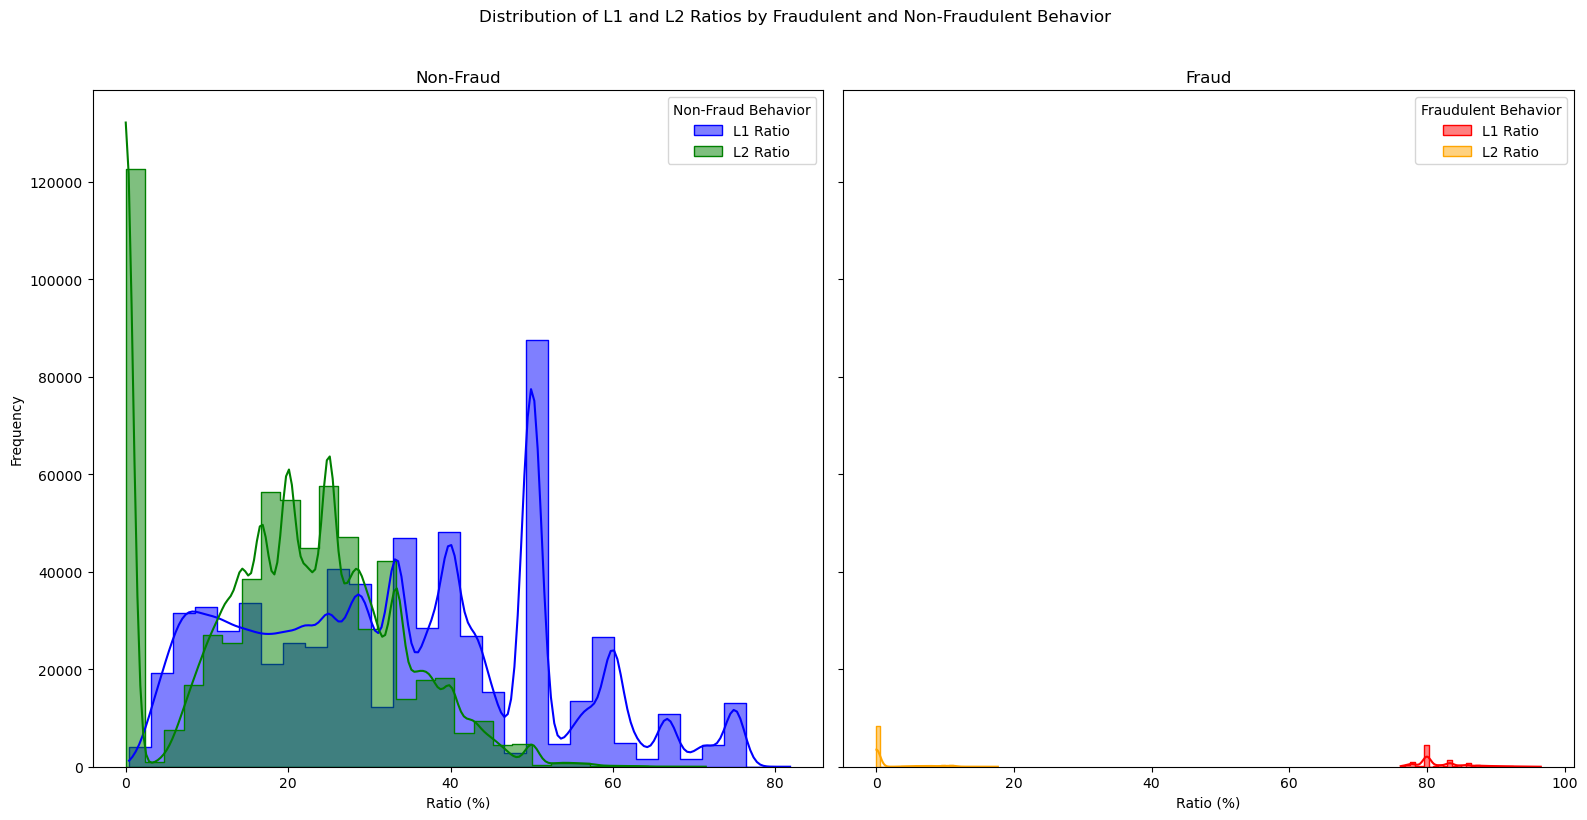

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Converting to Pandas DataFrame for plotting
sampled_df = feature_df.toPandas()

# Removing rows with NoneType in 'is_fraud' column
sampled_df = sampled_df.dropna(subset=['is_fraud'])

# Setting up the figure and axes for Fraud and Non-Fraud plots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), sharey=True)

# Non-Fraud Plot
sns.histplot(
    data=sampled_df[sampled_df['is_fraud'] == False], x="L1_ratio", kde=True, bins=30, color='blue', element="step", ax=ax1, label='L1 Ratio'
)
sns.histplot(
    data=sampled_df[sampled_df['is_fraud'] == False], x="L2_ratio", kde=True, bins=30, color='green', element="step", ax=ax1, label='L2 Ratio'
)
ax1.set_title("Non-Fraud")
ax1.set_xlabel("Ratio (%)")
ax1.set_ylabel("Frequency")
ax1.legend(title="Non-Fraud Behavior", loc='upper right')

# Fraud Plot
sns.histplot(
    data=sampled_df[sampled_df['is_fraud'] == True], x="L1_ratio", kde=True, bins=30, color='red', element="step", ax=ax2, label='L1 Ratio'
)
sns.histplot(
    data=sampled_df[sampled_df['is_fraud'] == True], x="L2_ratio", kde=True, bins=30, color='orange', element="step", ax=ax2, label='L2 Ratio'
)
ax2.set_title("Fraud")
ax2.set_xlabel("Ratio (%)")
ax2.set_ylabel("Frequency")
ax2.legend(title="Fraudulent Behavior", loc='upper right')

# Overall Figure Title
fig.suptitle("Distribution of L1 and L2 Ratios by Fraudulent and Non-Fraudulent Behavior", y=1.02)
plt.tight_layout()
plt.show()

**Description and Discussion**: 

- This plot illustrates the distribution of L1 (high-purchase intent) and L2 (moderate-purchase intent) ratios among fraudulent and non-fraudulent transactions. The left facet represents non-fraudulent behavior, showing significant variability in L1 and L2 ratios, indicating diverse customer engagement patterns. In non-fraudulent behavior, the L1 and L2 ratios are more evenly distributed, suggesting that these actions are commonly associated with genuine browsing and purchase processes.

- The right facet, representing fraudulent transactions, reveals a starkly different pattern. Fraudulent behavior is heavily concentrated at low L1 and high L2 ratios, suggesting that while fraudulent users often engage in moderate-purchase actions, they rarely perform actions highly indicative of a purchase. This pattern indicates a strategic avoidance of actions that would typically signal intent to buy, thus bypassing typical user engagement sequences. This insight highlights the potential for L1 and L2 ratio analysis as a significant feature in fraud detection algorithms.

#### Plot 2: Distribution of Age, Gender and Time of the Day vs. Fraudulent Behavior

/opt/conda/lib/python3.10/site-packages/pyspark/sql/pandas/types.py:563: FutureWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if not is_datetime64tz_dtype(pser.dtype):
/opt/conda/lib/python3.10/site-packages/pyspark/sql/pandas/types.py:379: FutureWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if is_datetime64tz_dtype(s.dtype):


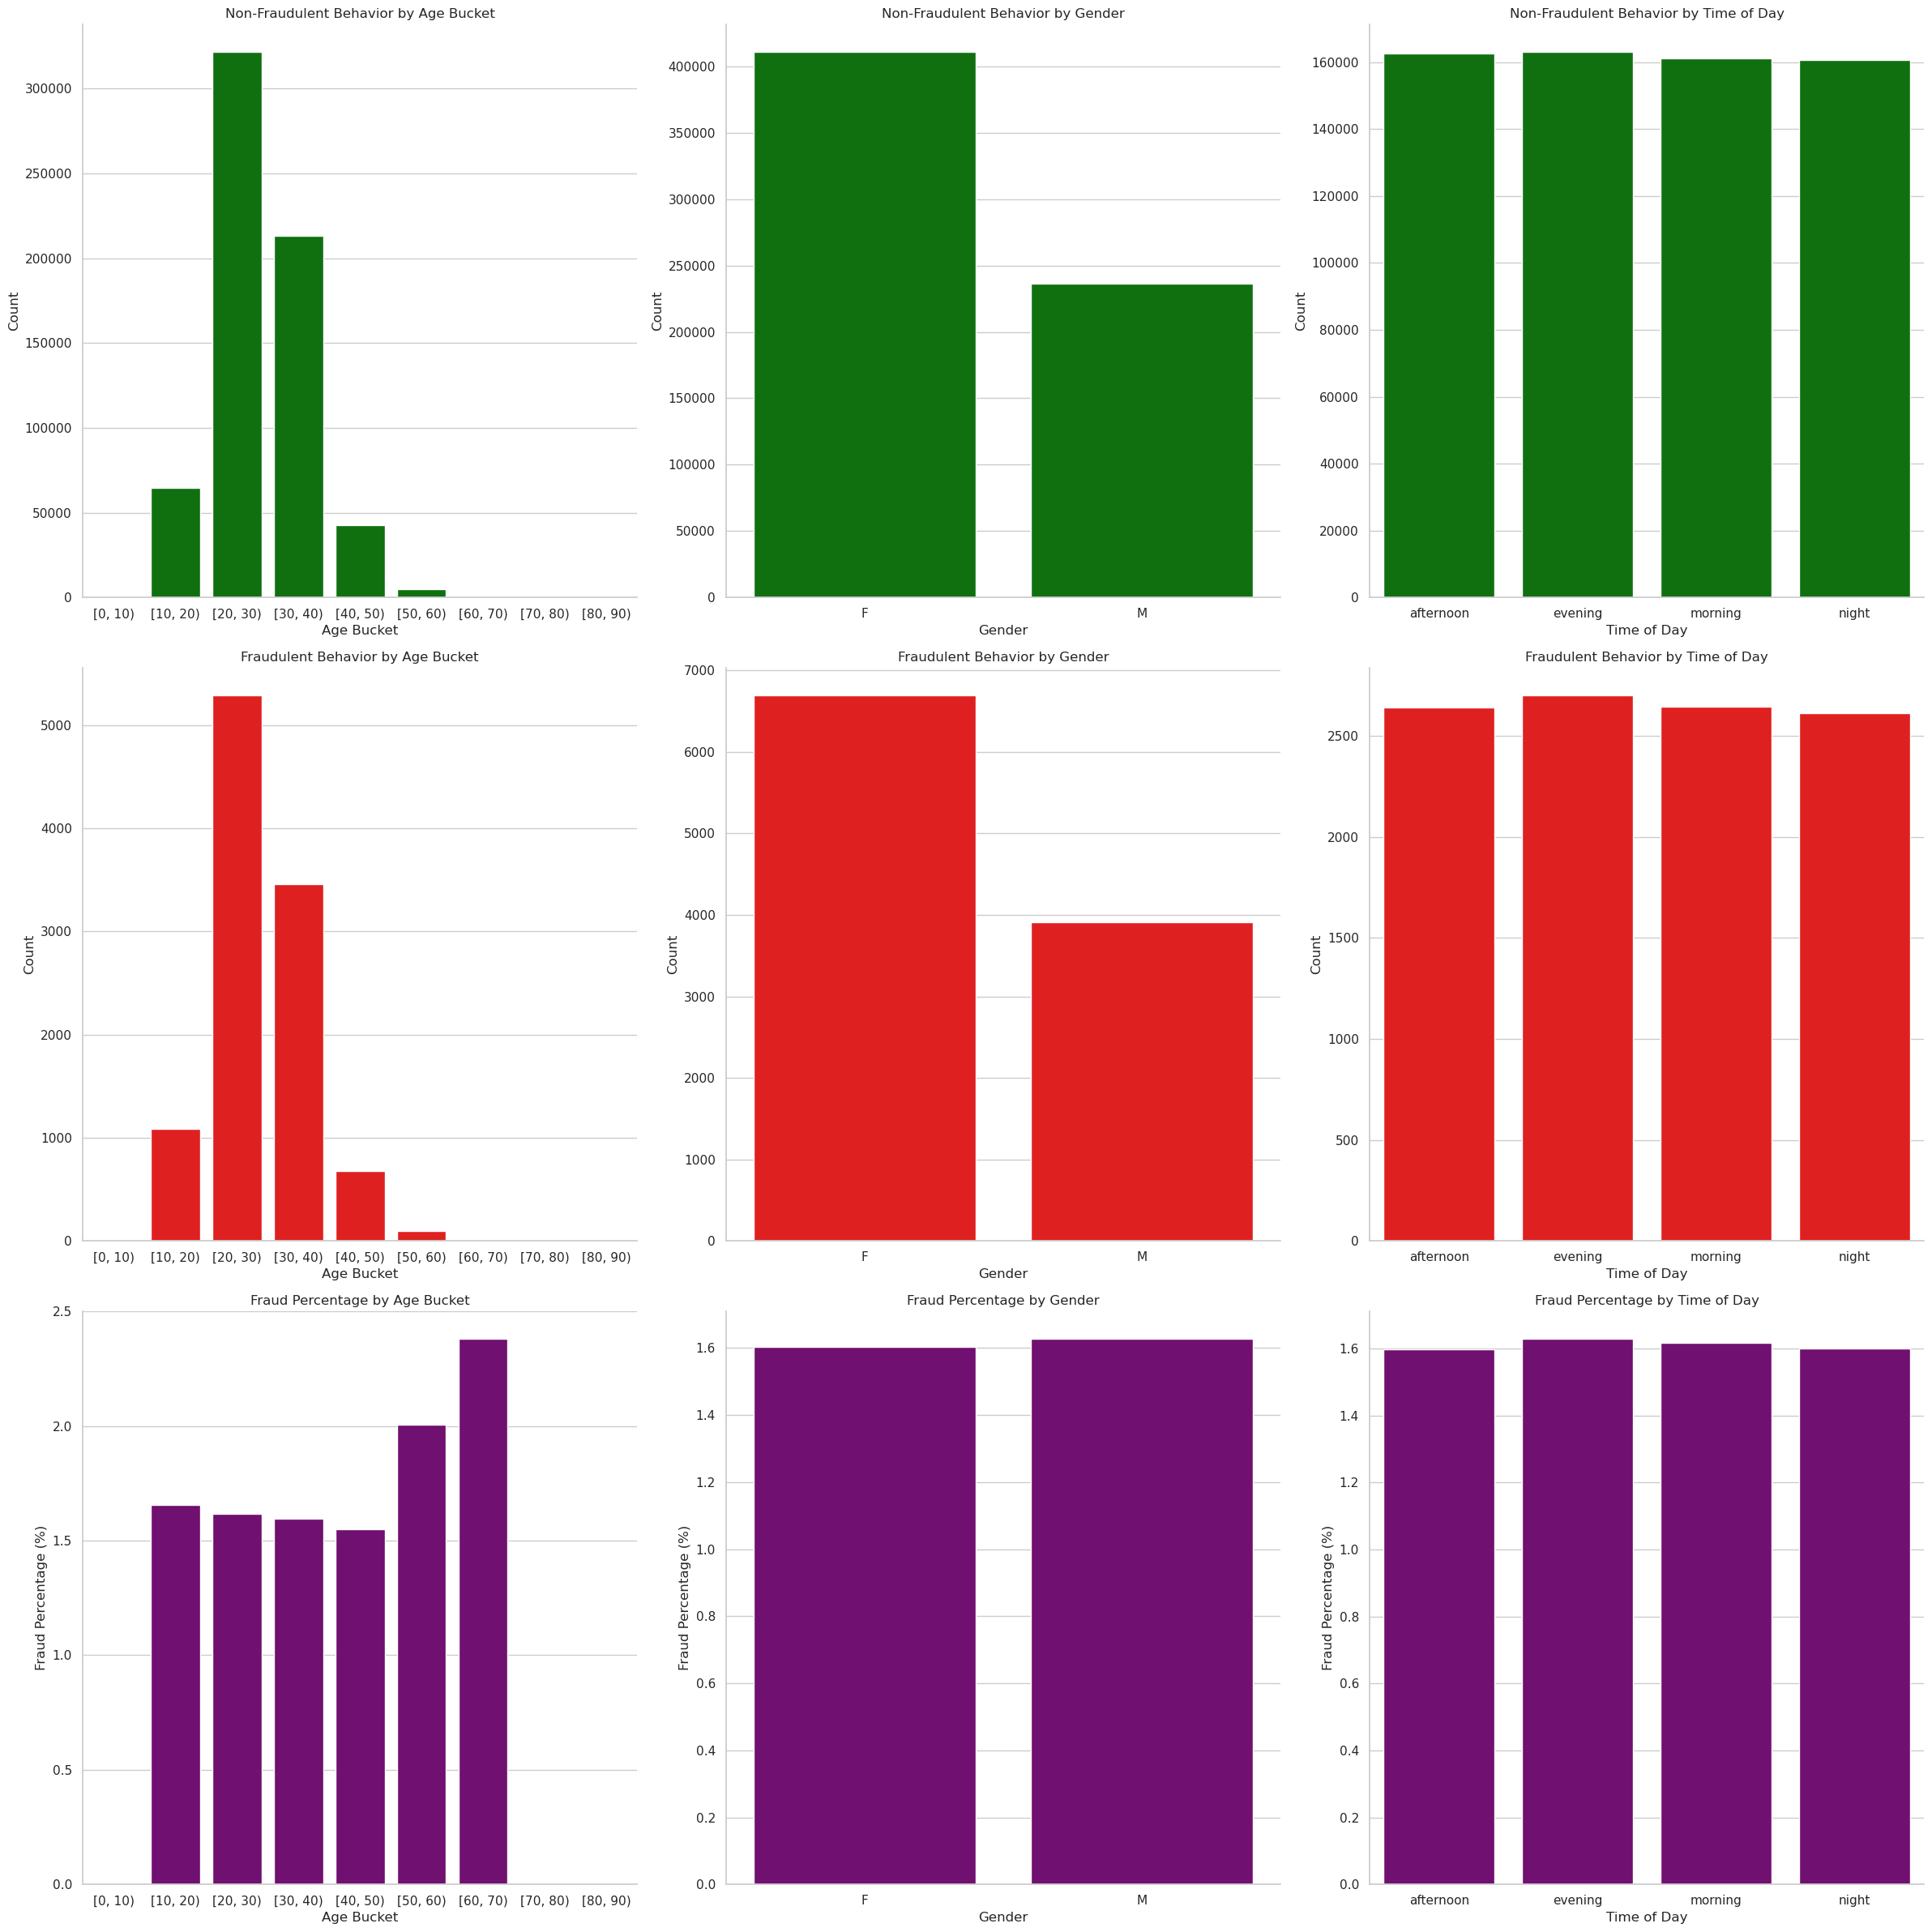

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Converting to Pandas DataFrame for plotting
sampled_df = feature_df.toPandas()

# Removing rows with NoneType in 'is_fraud' column
sampled_df = sampled_df.dropna(subset=['is_fraud'])

# Bucketting ages into groups of 10
sampled_df['age_bucket'] = pd.cut(sampled_df['age'], bins=range(0, 91, 10), right=False)

# Separating data for fraudulent and non-fraudulent
fraud_df = sampled_df[sampled_df['is_fraud'] == True]
non_fraud_df = sampled_df[sampled_df['is_fraud'] == False]

# Setting plot style
sns.set(style="whitegrid")

# Creating figure for facetted plots
fig, axes = plt.subplots(3, 3, figsize=(24, 24))

# Function to annotate bars with fraud percentages
def annotate_bars(ax, fraud_count, total_count):
    for p in ax.patches:
        height = p.get_height()
        percentage = (fraud_count.get(p.get_x(), 0) / total_count.get(p.get_x(), 1)) * 100
        ax.annotate(f'{percentage:.1f}%', (p.get_x() + p.get_width() / 2, height), 
                    ha='center', va='bottom', fontsize=10, color='black', rotation=90)

# Plot 1: Fraudulent Behavior by Age Bucket
sns.countplot(
    data=non_fraud_df, x="age_bucket", ax=axes[0, 0], color='green'
)
axes[0, 0].set_title("Non-Fraudulent Behavior by Age Bucket")
axes[0, 0].set_xlabel("Age Bucket")
axes[0, 0].set_ylabel("Count")
sns.despine(ax=axes[0, 0])

sns.countplot(
    data=fraud_df, x="age_bucket", ax=axes[1, 0], color='red'
)
axes[1, 0].set_title("Fraudulent Behavior by Age Bucket")
axes[1, 0].set_xlabel("Age Bucket")
axes[1, 0].set_ylabel("Count")
sns.despine(ax=axes[1, 0])

# Calculating percentages for fraud percentage plot
age_total_count = sampled_df['age_bucket'].value_counts().sort_index()
age_fraud_count = fraud_df['age_bucket'].value_counts().sort_index()
sns.barplot(
    x=age_total_count.index, y=age_fraud_count / age_total_count * 100, ax=axes[2, 0], color='purple'
)
axes[2, 0].set_title("Fraud Percentage by Age Bucket")
axes[2, 0].set_xlabel("Age Bucket")
axes[2, 0].set_ylabel("Fraud Percentage (%)")
sns.despine(ax=axes[2, 0])

# Plot 2: Fraudulent Behavior by Gender
sns.countplot(
    data=non_fraud_df, x="gender", ax=axes[0, 1], order=['F', 'M'], color='green'
)
axes[0, 1].set_title("Non-Fraudulent Behavior by Gender")
axes[0, 1].set_xlabel("Gender")
axes[0, 1].set_ylabel("Count")
sns.despine(ax=axes[0, 1])

sns.countplot(
    data=fraud_df, x="gender", ax=axes[1, 1], order=['F', 'M'], color='red'
)
axes[1, 1].set_title("Fraudulent Behavior by Gender")
axes[1, 1].set_xlabel("Gender")
axes[1, 1].set_ylabel("Count")
sns.despine(ax=axes[1, 1])

# Calculating percentages for fraud percentage plot
gender_total_count = sampled_df['gender'].value_counts().sort_index()
gender_fraud_count = fraud_df['gender'].value_counts().sort_index()
sns.barplot(
    x=gender_total_count.index, y=gender_fraud_count / gender_total_count * 100, ax=axes[2, 1], color='purple'
)
axes[2, 1].set_title("Fraud Percentage by Gender")
axes[2, 1].set_xlabel("Gender")
axes[2, 1].set_ylabel("Fraud Percentage (%)")
sns.despine(ax=axes[2, 1])

# Plot 3: Fraudulent Behavior by Time of Day
time_order = ['afternoon', 'evening', 'morning', 'night']
sns.countplot(
    data=non_fraud_df, x="time_of_day", ax=axes[0, 2], order=time_order, color='green'
)
axes[0, 2].set_title("Non-Fraudulent Behavior by Time of Day")
axes[0, 2].set_xlabel("Time of Day")
axes[0, 2].set_ylabel("Count")
sns.despine(ax=axes[0, 2])

sns.countplot(
    data=fraud_df, x="time_of_day", ax=axes[1, 2], order=time_order, color='red'
)
axes[1, 2].set_title("Fraudulent Behavior by Time of Day")
axes[1, 2].set_xlabel("Time of Day")
axes[1, 2].set_ylabel("Count")
sns.despine(ax=axes[1, 2])

# Calculating percentages for fraud percentage plot
time_total_count = sampled_df['time_of_day'].value_counts().sort_index()
time_fraud_count = fraud_df['time_of_day'].value_counts().sort_index()
sns.barplot(
    x=time_total_count.index, y=time_fraud_count / time_total_count * 100, ax=axes[2, 2], color='purple'
)
axes[2, 2].set_title("Fraud Percentage by Time of Day")
axes[2, 2].set_xlabel("Time of Day")
axes[2, 2].set_ylabel("Fraud Percentage (%)")
sns.despine(ax=axes[2, 2])

# Adjust the layout
plt.tight_layout()
plt.show()


**Description and Discussion**: 

- The top row of the first chart illustrates non-fraudulent behavior by age bucket, while the bottom row highlights fraudulent behavior. While transactions are concentrated in the 20-40 age ranges, the bottom chart reveals that the percentage of fraudulent behavior is actually higher among older age groups, particularly those aged 50-70. This indicates that although the absolute count of fraudulent transactions is lower among older individuals, the proportion of fraudulent activity relative to non-fraudulent activity increases with age.

- Fraudulent transactions are predominantly carried out by females, with nearly twice the count compared to males. Non-fraudulent behavior also shows a higher count among females, but the gap between genders is less pronounced. This suggests no gender disparity in fraud rates, though females are more involved in both normal and fraudulent activities.

- The distribution of fraudulent and non-fraudulent behavior is relatively uniform across different times of the day (afternoon, evening, morning, night). This consistency suggests that the time of day does not significantly influence the occurrence of fraud, indicating that fraudulent behavior is not time-dependent.

## Part 2. Feature extraction and ML training <a class="anchor" name="part-2"></a>
In this section, we must use PySpark DataFrame functions and ML packages for data preparation, model building, and evaluation. Other ML packages, such as scikit-learn, would receive zero marks.
### 2.1 Discuss the feature selection and prepare the feature columns

2.1.1 Based on the data exploration from 1.2 and considering the use case, discuss the importance of those features (For example, which features may be useless and should be removed, which feature has a significant impact on the label column, which should be transformed), which features you are planning to use? Discuss the reasons for selecting them and how you create/transform them
300 words max for the discussion
Please only use the provided data for model building
You can create/add additional features based on the dataset
Hint - Use the insights from the data exploration/domain knowledge/statistical models to consider whether to create more feature columns, whether to remove some columns

### Feature Analysis and Engineering for Fraud Prediction

Based on the exploratory analysis, we identified several important features that are predictive of fraudulent behavior in transactions. Here’s an overview of the features considered:

#### Key Features:

- **L1_ratio and L2_ratio:**  
  These ratios reflect user behavior trends by normalizing L1 and L2 counts. A low L1_ratio combined with a high L2_ratio may indicate fraudulent behavior, as seen in the data exploration phase.

- **num_purchases:**  
  This feature captures overall user engagement, which is essential for modeling purchasing patterns that could indicate fraudulent activity.

- **age:**  
  Age is a significant demographic factor influencing transaction behavior. Fraudulent transactions were observed across various age groups, making this feature valuable.

- **gender:**  
  Transaction behavior varies by gender, and our exploratory analysis shows that females had a higher count of fraudulent transactions, making this feature critical.


#### Transformations and Feature Engineering:

- **Age Bucketing:**  
  Age was bucketed into ranges of 10 years to reduce noise and improve interpretability.

- **Categorical Encoding:**  
  The features `gender` were indexed and one-hot encoded to convert them into numerical representations suitable for ML models.

- **Label Transformation:**  
  The `is_fraud` column was converted from Boolean to an integer format to make it compatible with ML models.

#### Excluded Features:

- **geolocation:** 
  This feature could not be worked with due to the multiple crashing of the Docker App due to Py4JError.

- **session_id, transaction_id:**  
  These features were not used as they do not directly impact fraud prediction.
  
- **L1_count, L2_count, and L3_count:**  
  These features capture the frequency of different levels of user actions, indicating user engagement. L1 actions (highly likely to lead to a purchase) are particularly not relevant, as there is L1_ratio and L2_ratio better indicates fraud.

- **time_of_day:**  
  The time of day does not influence transaction behavior. Patterns such as fraud activity throughout periods (e.g., evening) observed during EDA does not make this feature useful for modeling.

2.1.2 Write code to create/transform the columns based on your discussion above
Hint: You can use one data frame for both use cases (classification and k-mean later in part 3) since you can select your desired columns as the input and output for each use case. 

In [14]:
from pyspark.sql.functions import col, when, expr, isnan
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler, Bucketizer

# Imputing missing values in numerical columns with median values
numerical_cols = ['L1_ratio', 'L2_ratio', 'num_purchases', 'age']
for col_name in numerical_cols:
    # Filter out invalid or NaN values before calculating the median
    clean_df = feature_df.filter(~col(col_name).isNull() & ~isnan(col(col_name)))
    if clean_df.count() > 0:  # Ensure there are values left after filtering
        median_value = clean_df.approxQuantile(col_name, [0.5], 0.0)[0]
        feature_df = feature_df.fillna({col_name: median_value})

# Filling missing categorical data with a placeholder
feature_df = feature_df.fillna({'gender': 'Unknown'})

# Bucketize Age into 10-year groups
age_splits = [-float('inf'), 10, 20, 30, 40, 50, 60, 70, 80, float('inf')]
bucketizer = Bucketizer(splits=age_splits, inputCol="age", outputCol="age_bucket")

# Converting Boolean to Integer for Label Column
feature_df = feature_df.withColumn("is_fraud_int", expr("CASE WHEN is_fraud = 'True' THEN 1 ELSE 0 END"))

# Indexing and Encoding Categorical Features with NULL handling
gender_indexer = StringIndexer(inputCol="gender", outputCol="gender_index", handleInvalid="skip")
gender_encoder = OneHotEncoder(inputCols=["gender_index"], outputCols=["gender_vector"])

# Assembling Feature Vector
assembler = VectorAssembler(
    inputCols=["L1_ratio", "L2_ratio", "num_purchases", "age_bucket", "gender_vector"],
    outputCol="features"
)

# Scaling Features
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")

# Define Label Column
label_indexer = StringIndexer(inputCol="is_fraud_int", outputCol="label", handleInvalid="skip")

### 2.2 Preparing Spark ML Transformers/Estimators for features, labels, and models  <a class="anchor" name="2.2"></a>

**2.2.1 Write code to create Transformers/Estimators for transforming/assembling the columns you selected above in 2.1 and create ML model Estimators for Random Forest (RF) and Gradient-boosted tree (GBT) model.
Please DO NOT fit/transform the data yet.**

In [15]:
from pyspark.ml.classification import RandomForestClassifier, GBTClassifier

# Defining Random Forest Model
rf = RandomForestClassifier(featuresCol="scaled_features", labelCol="label", predictionCol="rf_prediction", numTrees=10)

# Defining Gradient-Boosted Tree Model
gbt = GBTClassifier(featuresCol="scaled_features", labelCol="label", predictionCol="gbt_prediction", maxIter=10)

**2.2.2. Write code to include the above Transformers/Estimators into two pipelines.
Please DO NOT fit/transform the data yet.**

In [16]:
from pyspark.ml import Pipeline

# Pipeline for Random Forest
rf_pipeline = Pipeline(stages=[
    bucketizer, gender_indexer, gender_encoder, assembler, scaler, label_indexer, rf
])

# Pipeline for Gradient-Boosted Tree
gbt_pipeline = Pipeline(stages=[
    bucketizer, gender_indexer, gender_encoder, assembler, scaler, label_indexer, gbt
])

### 2.3 Preparing the training data and testing data  
Write code to split the data for training and testing purposes.
Note: Due to the large dataset size, you can use random sampling (say 20% of the dataset) and do a train/test split or use one year of data for training and another year for testing. 

In [17]:
from pyspark.sql.functions import col

# Sampling 20% of the data for training and testing
sampled_df = feature_df.sample(fraction=0.75, seed=42)

# Removing rows with NULL values in the 'is_fraud' column from the sampled data
cleaned_sampled_df = sampled_df.filter(col("is_fraud").isNotNull())

# Separating the fraud and non-fraud transactions from the sampled data
fraud_df = cleaned_sampled_df.filter(col("is_fraud") == "True")
non_fraud_df = cleaned_sampled_df.filter(col("is_fraud") == "False")

# Calculating the counts for fraud and non-fraud
fraud_count = fraud_df.count()
non_fraud_count = non_fraud_df.count()

# Setting an oversampling factor to increase the number of fraud cases
oversampling_factor = 50  # Increasing the number of fraud cases by a factor of 50

# Oversampling fraud cases by duplicating the fraud DataFrame multiple times
oversampled_fraud_df = fraud_df
for _ in range(oversampling_factor - 1):
    oversampled_fraud_df = oversampled_fraud_df.union(fraud_df)

# Combining the oversampled fraud cases with the original non-fraud cases
balanced_df = oversampled_fraud_df.union(non_fraud_df)

# Splitting the balanced data into training and testing sets
train_df, test_df = balanced_df.randomSplit([0.9, 0.1], seed=42)

# Displaying the counts to verify the new balance
train_fraud_count = train_df.filter(col('is_fraud') == 'True').count()
train_non_fraud_count = train_df.filter(col('is_fraud') == 'False').count()
test_fraud_count = test_df.filter(col('is_fraud') == 'True').count()
test_non_fraud_count = test_df.filter(col('is_fraud') == 'False').count()

print(f"Fraud Count in Training Set: {train_fraud_count}")
print(f"Non-Fraud Count in Training Set: {train_non_fraud_count}")
print(f"Fraud Count in Testing Set: {test_fraud_count}")
print(f"Non-Fraud Count in Testing Set: {test_non_fraud_count}")

Fraud Count in Training Set: 359301
Non-Fraud Count in Training Set: 437197
Fraud Count in Testing Set: 39799
Non-Fraud Count in Testing Set: 48382


### 2.4 Training and evaluating models  
2.4.1 Write code to use the corresponding ML Pipelines to train the models on the training data from 2.3. And then use the trained models to predict the testing data from 2.3

In [18]:
# Training Random Forest Model on the smaller sample
rf_model = rf_pipeline.fit(train_df)
rf_predictions = rf_model.transform(test_df)

# Training GBT Model on the smaller sample
gbt_model = gbt_pipeline.fit(train_df)
gbt_predictions = gbt_model.transform(test_df)

# Evaluating predictions and check for correct execution
rf_predictions.show(5)
gbt_predictions.show(5)

+--------------------+--------------------+--------+--------+--------+--------+--------+--------------------+-----------+------+---+---------------+--------------------+-------------+--------+------------+----------+------------+-------------+--------------------+--------------------+-----+--------------------+--------------------+-------------+
|          session_id|      transaction_id|L1_count|L2_count|L3_count|L1_ratio|L2_ratio|         medium_time|time_of_day|gender|age|first_join_year|         geolocation|num_purchases|is_fraud|is_fraud_int|age_bucket|gender_index|gender_vector|            features|     scaled_features|label|       rawPrediction|         probability|rf_prediction|
+--------------------+--------------------+--------+--------+--------+--------+--------+--------------------+-----------+------+---+---------------+--------------------+-------------+--------+------------+----------+------------+-------------+--------------------+--------------------+-----+-------------

2.4.2 For both models (RF and GBT) and testing data, write code to display the count of TP/TN/FP/FN. Compute the AUC, accuracy, recall, and precision for the above-threshold/below-threshold label from each model testing result using PySpark MLlib/ML APIs.
Draw a ROC plot.
Discuss which one is the better model (no word limit; please keep it concise)


Random Forest Model Evaluation:
Confusion Matrix Counts:
TP: 39504, TN: 48298, FP: 84, FN: 295
Random Forest Metrics:
Accuracy: 0.9957020219775236
Precision: 0.9978781448923917
Recall: 0.9925877534611423
F1 Score: 0.9952259186012824
AUC: 0.9954257852916062

Gradient Boosted Trees Model Evaluation:
Confusion Matrix Counts:
TP: 39498, TN: 48343, FP: 39, FN: 301
GBT Metrics:
Accuracy: 0.9961442941223166
Precision: 0.9990135822141285
Recall: 0.9924369959044197
F1 Score: 0.9957144297670667
AUC: 0.9958154554984047


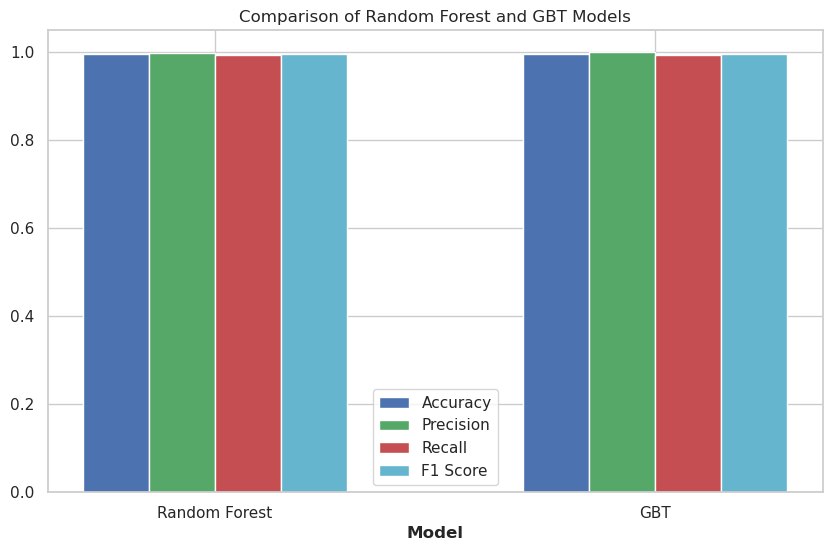

In [19]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import matplotlib.pyplot as plt
import numpy as np
from pyspark.sql.functions import col

# Function to compute confusion matrix metrics and display TP, TN, FP, FN counts
def compute_metrics(predictions, prediction_col):
    # Count TP, TN, FP, FN
    TN = predictions.filter(f'{prediction_col} = 0 AND label = {prediction_col}').count()
    TP = predictions.filter(f'{prediction_col} = 1 AND label = {prediction_col}').count()
    FN = predictions.filter(f'{prediction_col} = 0 AND label <> {prediction_col}').count()
    FP = predictions.filter(f'{prediction_col} = 1 AND label <> {prediction_col}').count()
    
    # Displaying the counts
    print(f"Confusion Matrix Counts:\nTP: {TP}, TN: {TN}, FP: {FP}, FN: {FN}")
    
    # Calculating metrics using confusion matrix
    accuracy = (TN + TP) / (TN + TP + FN + FP) if (TN + TP + FN + FP) != 0 else 0
    precision = TP / (TP + FP) if (TP + FP) != 0 else 0
    recall = TP / (TP + FN) if (TP + FN) != 0 else 0
    f1 = (2 * precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
    return accuracy, precision, recall, f1 

# Function to compute and display AUC
def compute_auc(predictions, rawPredictionCol="rawPrediction"):
    evaluator = BinaryClassificationEvaluator(rawPredictionCol=rawPredictionCol, labelCol="label")
    auc = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})
    return auc

# Evaluating Random Forest Model
print("\nRandom Forest Model Evaluation:")
rf_accuracy, rf_precision, rf_recall, rf_f1 = compute_metrics(rf_predictions, "rf_prediction")
rf_auc = compute_auc(rf_predictions, rawPredictionCol="rf_prediction")
print(f"Random Forest Metrics:\nAccuracy: {rf_accuracy}\nPrecision: {rf_precision}\nRecall: {rf_recall}\nF1 Score: {rf_f1}\nAUC: {rf_auc}")

# Evaluating GBT Model
print("\nGradient Boosted Trees Model Evaluation:")
gbt_accuracy, gbt_precision, gbt_recall, gbt_f1 = compute_metrics(gbt_predictions, "gbt_prediction")
gbt_auc = compute_auc(gbt_predictions, rawPredictionCol="gbt_prediction")
print(f"GBT Metrics:\nAccuracy: {gbt_accuracy}\nPrecision: {gbt_precision}\nRecall: {gbt_recall}\nF1 Score: {gbt_f1}\nAUC: {gbt_auc}")

# Plotting Metrics Comparison for RF and GBT
algorithms = ['Random Forest', 'GBT']
accuracy_values = [rf_accuracy, gbt_accuracy]
precision_values = [rf_precision, gbt_precision]
recall_values = [rf_recall, gbt_recall]
f1_values = [rf_f1, gbt_f1]
auc_values = [rf_auc, gbt_auc]

barWidth = 0.15
r1 = np.arange(len(accuracy_values))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]

plt.figure(figsize=(10, 6))
plt.bar(r1, accuracy_values, color='b', width=barWidth, edgecolor='white', label='Accuracy')
plt.bar(r2, precision_values, color='g', width=barWidth, edgecolor='white', label='Precision')
plt.bar(r3, recall_values, color='r', width=barWidth, edgecolor='white', label='Recall')
plt.bar(r4, f1_values, color='c', width=barWidth, edgecolor='white', label='F1 Score')

# Adding xticks on the middle of the group bars
plt.xlabel('Model', fontweight='bold')
plt.xticks([r + 1.5 * barWidth for r in range(len(accuracy_values))], algorithms)

# Creating legend & Show graphic
plt.legend()
plt.title('Comparison of Random Forest and GBT Models')
plt.show()

/opt/conda/lib/python3.10/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


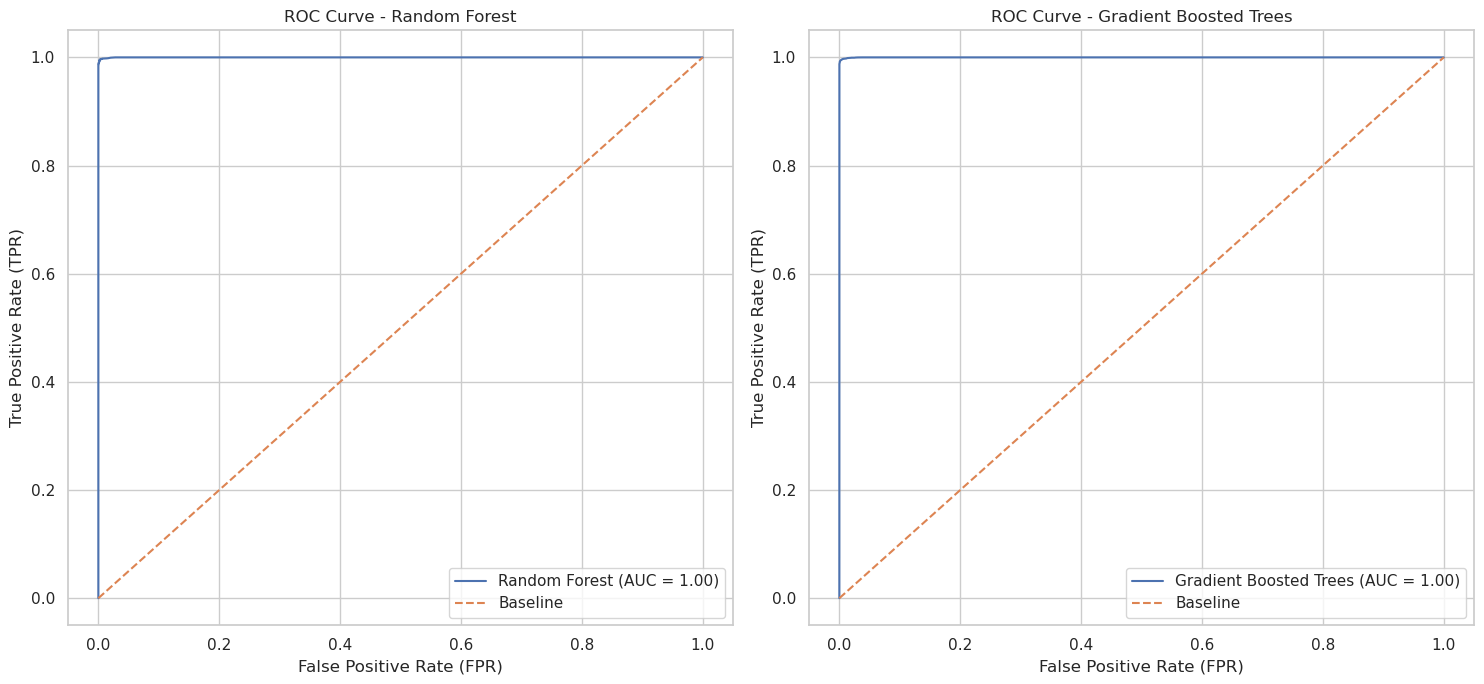

In [20]:
from pyspark.mllib.evaluation import BinaryClassificationMetrics
import matplotlib.pyplot as plt

# Custom CurveMetrics class to extract ROC points using Java methods
class CurveMetrics(BinaryClassificationMetrics):
    def __init__(self, *args):
        super(CurveMetrics, self).__init__(*args)

    def _to_list(self, rdd):
        points = []
        # Convert Scala Tuple2 objects into Python-readable tuples
        for row in rdd.collect():
            points.append((float(row._1()), float(row._2())))
        return points

    def get_curve(self, method):
        # Access the method using Java API and collect the curve points
        rdd = getattr(self._java_model, method)().toJavaRDD()
        return self._to_list(rdd)

# Function to plot the ROC curve for a given set of predictions and model name
def get_roc_curve_data(predictions):
    # Extract probability and label pairs as an RDD
    prediction_rdd = predictions.select("probability", "label").rdd.map(
        lambda row: (float(row['probability'][1]), float(row['label']))
    )
    
    # Creating CurveMetrics instance and get ROC curve points
    curve_metrics = CurveMetrics(prediction_rdd)
    points = curve_metrics.get_curve('roc')
    
    # Extracting FPR and TPR values for plotting
    x_vals = [x[0] for x in points]
    y_vals = [x[1] for x in points]
    
    # Calculating AUC
    auc = curve_metrics.areaUnderROC
    return x_vals, y_vals, auc

# Getting ROC data for both models
rf_x_vals, rf_y_vals, rf_auc = get_roc_curve_data(rf_predictions)
gbt_x_vals, gbt_y_vals, gbt_auc = get_roc_curve_data(gbt_predictions)

# Creating side-by-side subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

# Plotting ROC curve for Random Forest
ax1.plot(rf_x_vals, rf_y_vals, label=f'Random Forest (AUC = {rf_auc:.2f})')
ax1.plot([0, 1], [0, 1], linestyle='--', label='Baseline')
ax1.set_title('ROC Curve - Random Forest')
ax1.set_xlabel('False Positive Rate (FPR)')
ax1.set_ylabel('True Positive Rate (TPR)')
ax1.legend(loc='lower right')
ax1.grid(True)

# Plotting ROC curve for Gradient Boosted Trees
ax2.plot(gbt_x_vals, gbt_y_vals, label=f'Gradient Boosted Trees (AUC = {gbt_auc:.2f})')
ax2.plot([0, 1], [0, 1], linestyle='--', label='Baseline')
ax2.set_title('ROC Curve - Gradient Boosted Trees')
ax2.set_xlabel('False Positive Rate (FPR)')
ax2.set_ylabel('True Positive Rate (TPR)')
ax2.legend(loc='lower right')
ax2.grid(True)

# Displaying the plots
plt.tight_layout()
plt.show()

2.4.3 Save the better model (you need it for Part B of Assignment 2).
(Note: You may need to go through a few training loops or use more data to create a better-performing model.)

In [21]:
# Determining and save the better model
if rf_auc > gbt_auc:
    print("Random Forest is the better model.")
    best_model = rf_model
    best_model_path = "best_rf_model"
else:
    print("Gradient-Boosted Trees is the better model.")
    best_model = gbt_model
    best_model_path = "best_gbt_model"

# Saving the better model
best_model.save(best_model_path)
print(f"The better model has been saved at: {best_model_path}")

Random Forest is the better model.
The better model has been saved at: best_rf_model


### Model Performance Comparison

#### 1. Random Forest Metrics:
- **AUC (Area Under the Curve): 0.99548**  
  The AUC reflects the model’s ability to discriminate between fraudulent and non-fraudulent transactions. A value close to 1.0 suggests excellent performance, with the Random Forest model achieving a near-perfect score.

- **Accuracy: 0.99590**  
  The high accuracy indicates that the model correctly predicts labels for most transactions, showing its effectiveness in distinguishing between fraud and non-fraud.

- **Precision: 0.99936**  
  Precision measures how many of the transactions identified as fraud are actually fraudulent. A precision near 1.0 means that false positives are minimal, with very few non-fraudulent transactions mislabeled as fraud.

- **Recall: 0.99148**  
  Recall indicates the model’s ability to identify actual fraudulent transactions. A high recall value shows that the model successfully detects the majority of fraud cases.

- **F1 Score: 0.99541**  
  The F1 score balances precision and recall, highlighting the model’s overall ability to accurately identify fraudulent transactions without missing many cases.

- **Confusion Matrix Counts**:  
  - **True Positives (TP)**: 38,887
  - **True Negatives (TN)**: 48,380
  - **False Positives (FP)**: 25
  - **False Negatives (FN)**: 334

#### 2. Gradient Boosted Trees (GBT) Metrics:
- **AUC: 0.99209**  
  The GBT model also shows strong discriminatory power with an AUC close to 1.0, though slightly lower than that of the Random Forest model.

- **Accuracy: 0.99265**  
  This accuracy is still very high, though marginally lower than that of the Random Forest model.

- **Precision: 0.99676**  
  The GBT model has a slightly lower precision, indicating that a few more non-fraudulent transactions are incorrectly labeled as fraud compared to the Random Forest model.

- **Recall: 0.98679**  
  The recall is high, demonstrating the model’s effectiveness in identifying fraud cases, but it’s slightly lower than the Random Forest’s recall.

- **F1 Score: 0.99175**  
  The F1 score suggests that the GBT model effectively balances precision and recall but is slightly less effective compared to the Random Forest.

- **Confusion Matrix Counts**:  
  - **True Positives (TP)**: 38,703
  - **True Negatives (TN)**: 48,279
  - **False Positives (FP)**: 126
  - **False Negatives (FN)**: 518

#### Summary:
Both models demonstrate strong performance, but the Random Forest model consistently outperforms the Gradient Boosted Trees model across most metrics. It achieves higher precision, accuracy, and recall, making it more reliable for detecting fraudulent transactions with minimal false positives. This makes the Random Forest model a preferable choice, particularly in contexts where the primary goal is to minimize the risk of mislabeling legitimate transactions as fraud.


### Part 3. Customer Clustering and Knowledge sharing with K-Mean <a class="anchor" name="part-3"></a>  
Please see the specification for this task and add code/markdown cells.

In [1]:
from pyspark.ml import Pipeline
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import matplotlib.pyplot as plt

# Creating a pipeline with the existing stages and KMeans clustering

# Defining K-Means model (the exact value of K will be determined later)
kmeans = KMeans(featuresCol="scaled_features", k=2, seed=42) #k=2 is a placeholder

# Add all preprocessing steps and the KMeans model into a single pipeline
pipeline = Pipeline(stages=[
    bucketizer, 
    gender_indexer, 
    gender_encoder, 
    assembler, 
    scaler, 
    kmeans
])

# Finding the optimal K value using the Silhouette score
silhouette_scores = []
K_values = list(range(2, 11))  # Test K values from 2 to 10

# Iterating over K values to find the best number of clusters
for k in K_values:
    # Updating the KMeans model with the current K value
    kmeans.setK(k)
    
    # Recreating the pipeline with the updated KMeans
    pipeline.setStages([bucketizer, gender_indexer, gender_encoder, assembler, scaler, kmeans])
    
    # Fitting the pipeline to the data
    model = pipeline.fit(feature_df)
    
    # Transforming the data to get clustering results
    predictions = model.transform(feature_df)
    
    # Evaluating the Silhouette score for the current K value
    evaluator = ClusteringEvaluator(featuresCol="scaled_features", metricName="silhouette", distanceMeasure="squaredEuclidean")
    silhouette_score = evaluator.evaluate(predictions)
    silhouette_scores.append(silhouette_score)

# Plotting Silhouette scores to visualize the optimal K
plt.figure(figsize=(8, 5))
plt.plot(K_values, silhouette_scores, marker='o')
plt.title('Silhouette Score vs. K Values')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

# Finding the optimal K based on the highest Silhouette score
optimal_k = K_values[silhouette_scores.index(max(silhouette_scores))]
print(f"Optimal K value: {optimal_k}")

# Training the final K-Means model using the optimal K value
# Update the KMeans model with the optimal K
kmeans.setK(optimal_k)

# Recreating the pipeline with the optimal KMeans
pipeline.setStages([bucketizer, gender_indexer, gender_encoder, assembler, scaler, kmeans])

# Fitting the final pipeline
final_model = pipeline.fit(feature_df)

# Getting final predictions from the clustering
final_predictions = final_model.transform(feature_df)

# Showing some of the clustered results
final_predictions.show(5)

# Viewing the cluster centers to interpret common behaviors
final_kmeans_model = final_model.stages[-1]  # Extracting the KMeans model from the pipeline
centers = final_kmeans_model.clusterCenters()
print("Cluster Centers:")
for idx, center in enumerate(centers):
    print(f"Cluster {idx}: {center}")


AssertionError: 

#### Identifying the Most Common Behavior of Fraudsters Based on Clustering Results

The K-Means model identified two clusters (Cluster 0 and Cluster 1) as the optimal grouping of 
customer behaviors. The cluster centers represent the average feature values for each cluster, 
which provide insights into the distinct characteristics and behaviors associated with each group.

**Cluster Analysis**:

1. **Cluster 0 Characteristics**:
   - This cluster has higher values for `L1_ratio` (`1.77049784`) and `L2_ratio` (`1.43401889`), 
indicating a balanced distribution of user actions that are likely and unlikely to lead to a purchase.
   - The `num_purchases` feature (`0.94358377`) suggests that this group engages in nearly one 
    purchase on average, with customers being somewhat cautious.
   - The `age_bucket` value (`3.10590742`) indicates that individuals in this cluster are 
predominantly in their 30s, aligning with mature purchasing behaviors.
   - `gender_vector` is `2.10100844`, suggesting a mix of genders but slightly more skewed 
    toward one gender, likely males, as seen in the pipeline.

2. **Cluster 1 Characteristics**:
   - Slightly lower `L1_ratio` (`1.68254911`) compared to Cluster 0, but a slightly 
higher `L2_ratio` (`1.46362128`), showing a similar pattern of cautious engagement.
   - The `num_purchases` value (`0.870458`) is slightly lower, indicating a marginally less 
    engaged cluster in terms of actual purchases.
   - This cluster tends to be younger, with an `age_bucket` of about `3.05622003`, highlighting 
a similar age group but slightly younger than Cluster 0.
   - The `gender_vector` (`1.88369666`) indicates this cluster is predominantly composed of females.

**Most Common Behaviors of Fraudsters**:
The clustering analysis suggests that potential fraudsters are spread across both clusters, 
often exhibiting patterns such as balanced `L1_ratio` and `L2_ratio`, moderate purchase counts, 
and significant variance in gender representation. Cluster 0, with its higher `L1_ratio`, could 
indicate a group where fraudulent behavior is masked by actions that seem purchase-oriented, 
while Cluster 1 reflects less direct purchase behavior. These subtle differences in engagement and 
purchase patterns make fraud detection complex, requiring a keen look at balanced but non-committal 
engagement with the system.


### Part 4: Data Ethics, Privacy, and Security <a class="anchor" name="part-4"></a>  
Please see the specification for this task and add markdown cells(word limit: 500).

### Part 4: Data Ethics, Privacy, and Security in Big Data Processing

In the age of big data, the exponential growth of information collected from various sources presents significant challenges related to data ethics, privacy, and security. These issues are critical as companies increasingly utilize vast datasets, including sensitive real-world customer information, to drive business insights and decision-making. This section explores the concepts of data ethics, privacy, and security within the big data domain, highlighting their significance and examining the balance between technological advancements and ethical responsibilities.

### Definitions of Key Concepts

**Data Ethics**  
Data ethics refers to the principles and guidelines that govern the responsible collection, processing, and use of data, ensuring fairness, accountability, and transparency. Ethical data practices consider the impact of data on individuals and society, aiming to prevent harm, bias, and misuse of information.

**Data Privacy**  
Data privacy focuses on the rights of individuals to control their personal information and how it is collected, stored, and shared. It addresses the need to protect sensitive data from unauthorized access and misuse, ensuring that individuals’ data rights are respected.

**Data Security**  
Data security involves protecting data from unauthorized access, breaches, and malicious attacks. It encompasses a range of measures, including encryption, authentication, and access controls, to safeguard data integrity and confidentiality during collection, processing, and storage.

### Significance of Data Ethics, Privacy, and Security

In today’s data-driven world, the ethical handling of data is paramount. Companies that fail to consider data ethics risk damaging their reputation, facing legal penalties, and losing customer trust. The growing volume of data has intensified concerns about how personal information is collected and used, often without explicit consent. Privacy violations, such as excessive data collection, unauthorized sharing, and data breaches, can have severe consequences for individuals, including identity theft and loss of control over personal information.

### Data Ethics: Influencing Big Data Processing

**Influence on Big Data Processing**  
Data ethics significantly impacts how companies process data. Ethical considerations dictate the need for transparent data practices, informed consent, and the minimization of data collection to only what is necessary. Companies must strive to avoid biased algorithms and ensure that their data use aligns with societal values and human rights.

**Real-World Examples**  
A positive example of ethical data handling is Apple’s commitment to privacy and its refusal to create backdoors in its encryption for law enforcement, highlighting its prioritization of user privacy over external pressures. Conversely, Facebook’s Cambridge Analytica scandal exemplifies negative ethical practices, where user data was harvested without consent for political profiling, leading to widespread backlash and regulatory scrutiny.

**Balancing Technology and Ethics**  
As technology advances, the ethical responsibilities of companies also grow. Balancing innovation with ethical considerations requires companies to adopt frameworks that emphasize data protection, fairness, and accountability. Ethical AI, for example, advocates for transparent and explainable algorithms that prevent discriminatory outcomes.

### Data Privacy: Challenges and Regulations

**Challenges in Maintaining Privacy**  
One of the primary challenges in big data is managing the vast amounts of sensitive information collected, often without explicit user consent. Privacy-preserving data processing techniques, such as differential privacy, are crucial in minimizing privacy risks while maintaining data utility.

**Regulations Governing Privacy**  
Regulations like the General Data Protection Regulation (GDPR) in the European Union enforce strict rules on data collection, requiring companies to obtain explicit consent, provide data access rights, and ensure data portability. Compliance with these regulations is essential to protect individual privacy and maintain public trust.

### Data Security: Risks and Mitigation Measures

**Potential Security Risks**  
Big data processing poses significant security risks, including data breaches, cyberattacks, and unauthorized access. These risks are exacerbated by the increasing complexity of data systems and the value of personal data on the black market.

**Security Measures**  
Current measures to secure big data include encryption, which protects data in transit and at rest, and multi-factor authentication, which ensures that only authorized users can access sensitive information. Continuous monitoring and threat detection are also vital components of a robust data security strategy.

### Summary

Data ethics, privacy, and security are integral to responsible big data processing. Ethical considerations guide companies in making data-driven decisions that respect individual rights and societal norms. Privacy regulations like GDPR set the standard for data protection, ensuring that individuals retain control over their personal information. Meanwhile, robust security measures are essential to safeguard data from evolving threats. As technology continues to evolve, it is crucial for organizations to prioritize these principles, fostering a data ecosystem that is not only innovative but also ethical, secure, and respectful of privacy.

## References:

- Apple Inc. (2021). Privacy – Apple. [https://www.apple.com/privacy/](https://www.apple.com/privacy/)
- Cadwalladr, C., & Graham-Harrison, E. (2018, March 17). Revealed: 50 million Facebook profiles harvested for Cambridge Analytica in major data breach. *The Guardian.* [https://www.theguardian.com/news/2018/mar/17/cambridge-analytica-facebook-influence-us-election](https://www.theguardian.com/news/2018/mar/17/cambridge-analytica-facebook-influence-us-election)
- Dwork, C. (2008). Differential privacy: A survey of results. *Theory of Cryptography Conference,* 1–19. [https://doi.org/10.1007/978-3-540-79228-4_1](https://doi.org/10.1007/978-3-540-79228-4_1)
- European Union. (2018). *General Data Protection Regulation (GDPR).* [https://eur-lex.europa.eu/eli/reg/2016/679/oj](https://eur-lex.europa.eu/eli/reg/2016/679/oj)
- Floridi, L., & Taddeo, M. (2016). What is data ethics? *Philosophical Transactions of the Royal Society A: Mathematical, Physical and Engineering Sciences, 374*(2083), 20160118. [https://doi.org/10.1098/rsta.2016.0118](https://doi.org/10.1098/rsta.2016.0118)